# Midterm Project - Employee Retention Prediction

In [109]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

import xgboost as xgb

import pickle

In [110]:
df_full = pd.read_csv('HR_data.csv')
df_full.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## EDA

In [3]:
df_full.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [4]:
df_full.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64

**Rename columns and cleanup some of the data**

In [5]:
df = df_full

df.columns = df.columns.str.replace(' ', '_').str.lower()

df.rename(columns = {'satisfaction_level':'satisfaction_rating'}, inplace = True)
df.rename(columns = {'number_project':'number_of_projects'}, inplace = True)
df.rename(columns = {'average_montly_hours':'average_monthly_hours'}, inplace = True)
df.rename(columns = {'time_spend_company':'tenure'}, inplace = True)
df.rename(columns = {'work_accident':'work_accidents'}, inplace = True)
df.rename(columns = {'left':'termination'}, inplace = True)

df

,satisfaction_rating,last_evaluation,number_of_projects,average_monthly_hours,tenure,work_accidents,termination,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


In [6]:
df.termination.value_counts()

0    11428
1     3571
Name: termination, dtype: int64

In [7]:
len(df.termination[df.termination == 1])/len(df.termination[df.termination == 0])

0.31247812390619534

**31% of people were terminated**

In [8]:
numerical = df.select_dtypes(include=np.number).columns.tolist()
numerical

['satisfaction_rating',
 'last_evaluation',
 'number_of_projects',
 'average_monthly_hours',
 'tenure',
 'work_accidents',
 'termination',
 'promotion_last_5years']

In [9]:
categorical = df.select_dtypes(exclude=np.number).columns.tolist()
categorical

['department', 'salary']

In [10]:
df_nums = df.copy()
df_nums = df_nums[numerical]
df_nums.describe()

,satisfaction_rating,last_evaluation,number_of_projects,average_monthly_hours,tenure,work_accidents,termination,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


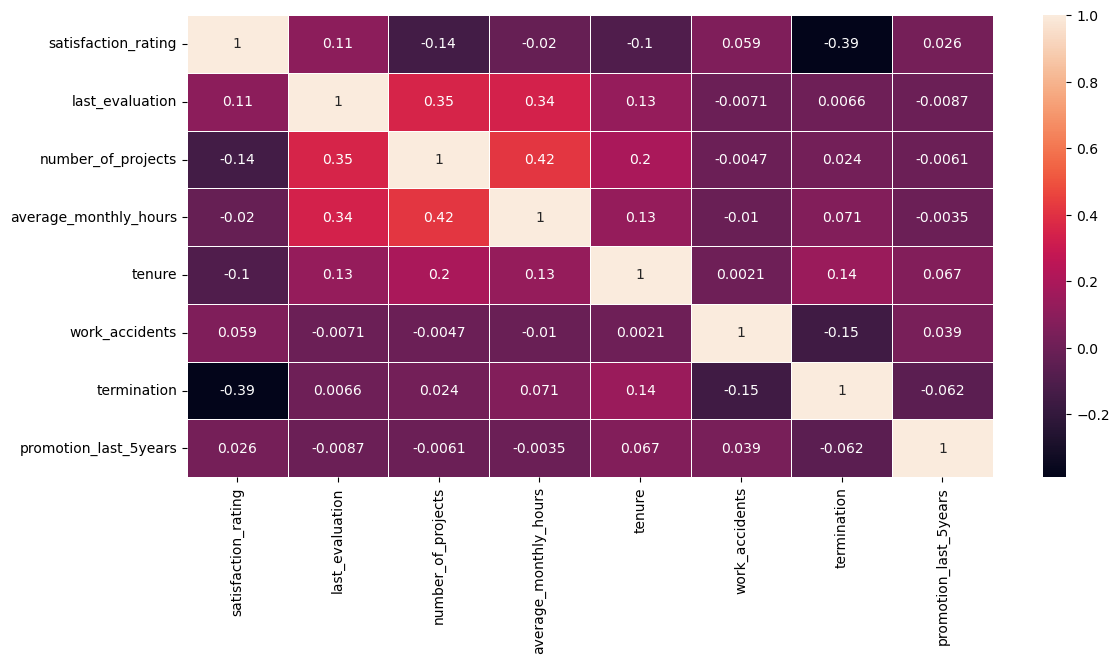

In [11]:
plt.figure(figsize=(13,6))
corr_matrix = df_nums.corr()
sn.heatmap(corr_matrix, linewidths=.7, annot=True)
plt.show()

In [12]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.termination.values
y_val = df_val.termination.values
y_test = df_test.termination.values

del df_train['termination']
del df_val['termination']
del df_test['termination']

len(df_train), len(df_val), len(df_test)

(8999, 3000, 3000)

In [13]:
cols = ['satisfaction_rating','last_evaluation','number_of_projects','average_monthly_hours','tenure','work_accidents','promotion_last_5years','department','salary']

In [14]:
train_dicts = df_train[cols].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dict = df_val[cols].to_dict(orient='records')
X_val = dv.transform(val_dict)

## Logistic Regression

In [15]:
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [16]:
y_pred = model.predict_proba(X_val)[:, 1]
termination_decision = (y_pred >= 0.5)
accuracy = (y_val == termination_decision).mean()
accuracy

0.784

In [17]:
accuracy_score(y_val, y_pred >= 0.5)

0.784

In [18]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.238
0.05 0.383
0.10 0.547
0.15 0.648
0.20 0.706
0.25 0.747
0.30 0.775
0.35 0.789
0.40 0.792
0.45 0.794
0.50 0.784
0.55 0.771
0.60 0.778
0.65 0.779
0.70 0.775
0.75 0.766
0.80 0.760
0.85 0.761
0.90 0.762
0.95 0.762
1.00 0.762


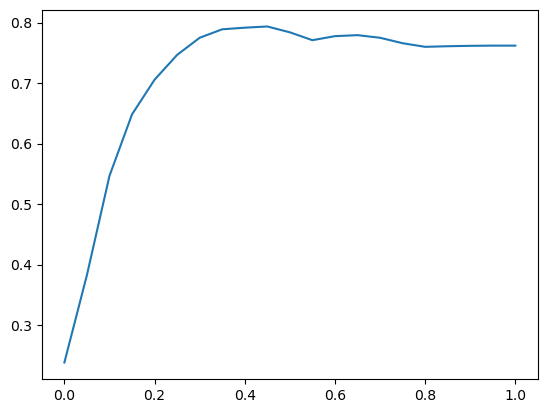

In [19]:
plt.plot(thresholds, scores)

In [20]:
accuracy_score(y_val, y_pred >= 0.45)

0.7936666666666666

**0.45 threshold looks to perform the best**

## Decision Tree

In [21]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [22]:
val_dicts = df_val[cols].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [23]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.9698934691987032

In [24]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [25]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.9110463478559065
val: 0.9029297195693676


In [26]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- satisfaction_rating <= 0.47
|   |--- number_of_projects <= 2.50
|   |   |--- class: 1
|   |--- number_of_projects >  2.50
|   |   |--- class: 0
|--- satisfaction_rating >  0.47
|   |--- tenure <= 4.50
|   |   |--- class: 0
|   |--- tenure >  4.50
|   |   |--- class: 0



**Tuning max_depth**

In [27]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.783
   2 -> 0.903
   3 -> 0.962
   4 -> 0.965
   5 -> 0.970
   6 -> 0.975
  10 -> 0.969
  15 -> 0.972
  20 -> 0.970
None -> 0.969


**Tuning min_samples_leaf**

In [28]:
scores = []

for depth in [5, 6, 10]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [29]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [30]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth            5      6      10
min_samples_leaf                     
1                 0.970  0.975  0.968
5                 0.974  0.979  0.976
10                0.974  0.979  0.977
15                0.977  0.981  0.982
20                0.977  0.980  0.982
100               0.971  0.973  0.977
200               0.970  0.971  0.973
500               0.962  0.963  0.962

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

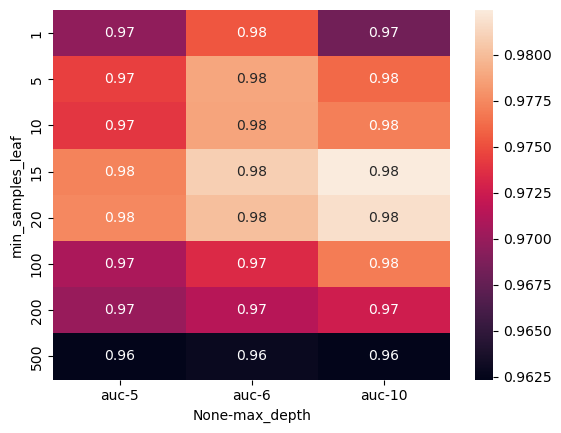

In [31]:
sn.heatmap(df_scores_pivot, annot=True)

In [32]:
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=15)

In [33]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- satisfaction_rating <= 0.47
|   |--- number_of_projects <= 2.50
|   |   |--- last_evaluation <= 0.57
|   |   |   |--- last_evaluation <= 0.44
|   |   |   |   |--- class: 0
|   |   |   |--- last_evaluation >  0.44
|   |   |   |   |--- average_monthly_hours <= 165.00
|   |   |   |   |   |--- average_monthly_hours <= 126.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- average_monthly_hours >  126.50
|   |   |   |   |   |   |--- satisfaction_rating <= 0.37
|   |   |   |   |   |   |   |--- average_monthly_hours <= 142.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- average_monthly_hours >  142.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- satisfaction_rating >  0.37
|   |   |   |   |   |   |   |--- salary=high <= 0.50
|   |   |   |   |   |   |   |   |--- department=sales <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- department=sales >  0.50
|   |   |   | 

**Looks like the best parameters for Decision Tree are:**
   - max_depth=10
   - min_samples_leaf=15

## Random Forest

In [34]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [35]:
y_pred = rf.predict_proba(X_val)[:, 1]

In [36]:
roc_auc_score(y_val, y_pred)

0.9844039102955269

**Tuning max_depth**

In [37]:
scores = []

for d in [5, 10, 15, 20, 25, 30, 40, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [38]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

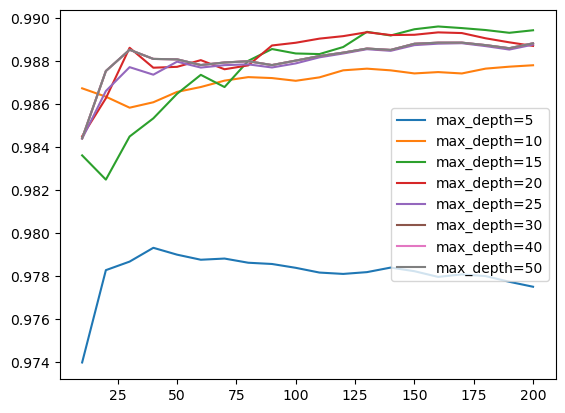

In [39]:
for d in [5, 10, 15, 20, 25, 30, 40, 50]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [40]:
max_depth = 15

**Tuning min_samples_leaf**

In [41]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [42]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

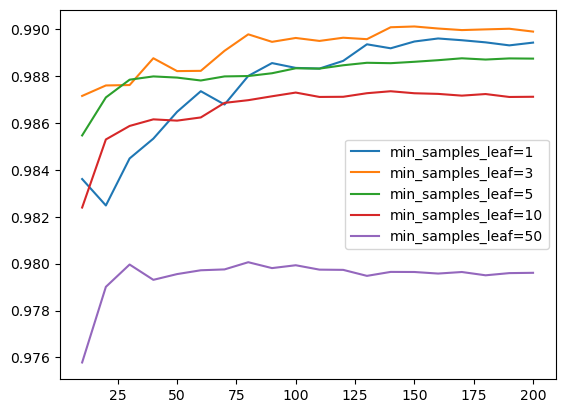

In [43]:
values = [1, 3, 5, 10, 50]

for s in values:
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [44]:
min_samples_leaf = 3

In [45]:
rf = RandomForestClassifier(n_estimators=150,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=3, n_estimators=150,
                       random_state=1)

**Looks like the best parameters for Random Forest are:**
   - max_depth=5
   - min_samples_leaf=3
   - n_estimators=150

### XGBoost

In [46]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [47]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200)

In [48]:
y_pred = model.predict(dval)

In [49]:
roc_auc_score(y_val, y_pred)

0.9918080092929561

In [50]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

scores = {}

In [51]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train', 'val']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

**Tuning eta**

In [52]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [53]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.3'

In [54]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [55]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.1'

In [56]:
%%capture output

xgb_params = {
    'eta': 1.0, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [57]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=1.0'

In [58]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [59]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [60]:
%%capture output

xgb_params = {
    'eta': 0.05, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [61]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.05'

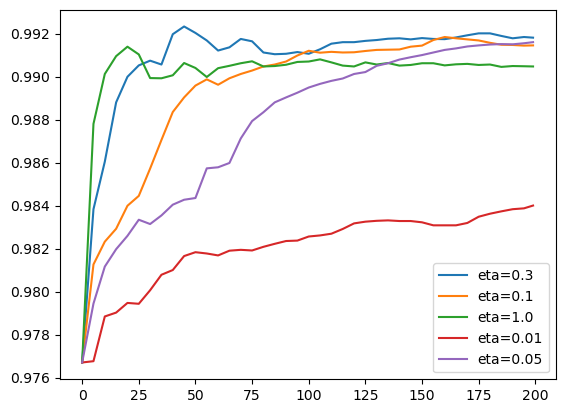

In [62]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val, label=key)

plt.legend()

In [63]:
eta=0.3

**Tuning max_depth**

In [64]:
scores = {}

In [65]:
%%capture output

xgb_params = {
    'eta': eta, 
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [66]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=3'

In [67]:
%%capture output

xgb_params = {
    'eta': eta, 
    'max_depth': 4,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [68]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=4'

In [69]:
%%capture output

xgb_params = {
    'eta': eta, 
    'max_depth': 5,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [70]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=5'

In [71]:
%%capture output

xgb_params = {
    'eta': eta, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [72]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=6'

In [73]:
%%capture output

xgb_params = {
    'eta': eta, 
    'max_depth': 8,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [74]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=8'

In [75]:
%%capture output

xgb_params = {
    'eta': eta, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [76]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

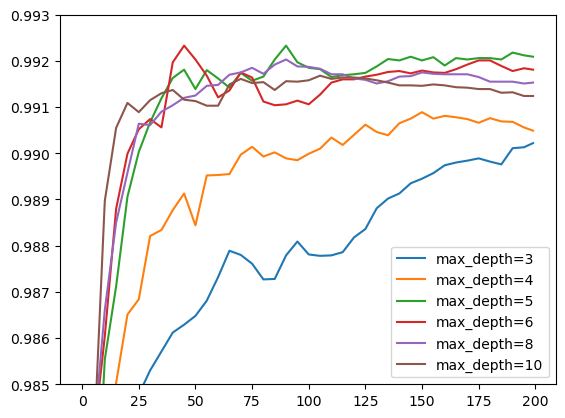

In [77]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val, label=key)
    
plt.ylim(0.985, 0.993)
plt.legend()

In [78]:
max_depth=5

**Tuning min_child_weight**

In [79]:
scores = {}

In [80]:
%%capture output

xgb_params = {
    'eta': eta, 
    'max_depth': max_depth,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [81]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=1'

In [82]:
%%capture output

xgb_params = {
    'eta': eta, 
    'max_depth': max_depth,
    'min_child_weight': 10,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [83]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=10'

In [84]:
%%capture output

xgb_params = {
    'eta': eta, 
    'max_depth': max_depth,
    'min_child_weight': 20,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [85]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=20'

In [86]:
%%capture output

xgb_params = {
    'eta': eta, 
    'max_depth': max_depth,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [87]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

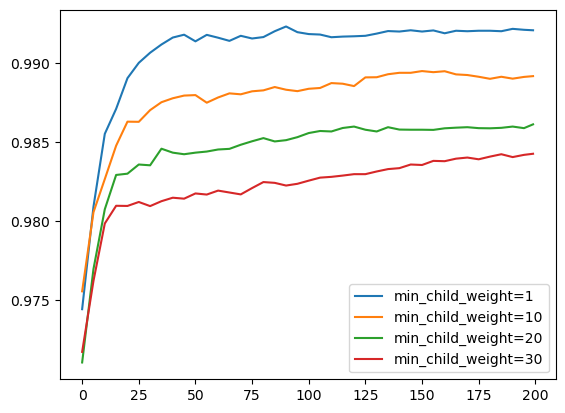

In [88]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val, label=key)
    
plt.legend()

In [89]:
min_child_weight=1

**Looks like the best parameters for XGBoost are:**
   - eta=0.3
   - max_depth=5
   - min_child_weight=1
   - num_boost_round=90

## Selecting a Model

### Decision Tree

In [90]:
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=15)

In [91]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.9825236306246032

### Random Forest

In [92]:
rf = RandomForestClassifier(n_estimators=150,
                            max_depth=5,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=3, n_estimators=150,
                       random_state=1)

In [93]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.9783231752893632

### XGBoost

In [94]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 5,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=90,
                  verbose_eval=5,
                  evals=watchlist)

In [95]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.9922619966621818

**XGBoost is the most accurate**

## Training the model on the full dataset 

In [96]:
df_train_full.head()

,satisfaction_rating,last_evaluation,number_of_projects,average_monthly_hours,tenure,work_accidents,termination,promotion_last_5years,department,salary
2560,0.68,0.70,4,185,4,0,0,0,technical,medium
12305,0.45,0.47,2,135,3,0,1,0,RandD,medium
6513,0.70,0.99,5,135,4,0,0,0,sales,medium
7083,0.58,0.58,3,122,3,0,0,0,management,high
6952,0.97,0.58,4,187,4,1,0,0,management,high


In [97]:
df_train_full = df_train_full.reset_index(drop=True)

In [98]:
df_train_full.head()

,satisfaction_rating,last_evaluation,number_of_projects,average_monthly_hours,tenure,work_accidents,termination,promotion_last_5years,department,salary
0,0.68,0.70,4,185,4,0,0,0,technical,medium
1,0.45,0.47,2,135,3,0,1,0,RandD,medium
2,0.70,0.99,5,135,4,0,0,0,sales,medium
3,0.58,0.58,3,122,3,0,0,0,management,high
4,0.97,0.58,4,187,4,1,0,0,management,high


In [99]:
y_train_full = df_train_full.termination.values

In [100]:
del df_train_full['termination']

In [101]:
dicts_train_full = df_train_full.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train_full = dv.fit_transform(dicts_train_full)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [105]:
dtrainfull = xgb.DMatrix(X_train_full, label=y_train_full,
                    feature_names = list(dv.get_feature_names_out()))

dtest = xgb.DMatrix(X_test, feature_names = list(dv.get_feature_names_out()))

In [119]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 5,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrainfull, num_boost_round=90,
                  verbose_eval=5,)

In [120]:
y_pred = model.predict(dtest)

In [121]:
roc_auc_score(y_test, y_pred)

0.9946707746878355

In [135]:
df_train_full.iloc[3].to_dict()

{'satisfaction_rating': 0.58,
 'last_evaluation': 0.58,
 'number_of_projects': 3,
 'average_monthly_hours': 122,
 'tenure': 3,
 'work_accidents': 0,
 'promotion_last_5years': 0,
 'department': 'management',
 'salary': 'high'}

In [136]:
y_train_full[3]

0

## Exporting Model

In [122]:
output_file = 'model.bin'

In [123]:
f_out = open(output_file, 'wb') 
pickle.dump((dv, model), f_out)
f_out.close()